## Crude Oil

### Weekly

All missing values handled successfully!
Epoch 1/100


C:\Users\dipes\AppData\Local\Temp\ipykernel_7340\2256607099.py:19: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['Date'] = pd.to_datetime(data['Date'])


44/44 [==============================] - 1s 8ms/step - loss: 0.0265 - mae: 0.1048 - val_loss: 0.0051 - val_mae: 0.0516
Epoch 2/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0038 - mae: 0.0396 - val_loss: 0.0041 - val_mae: 0.0478
Epoch 3/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0035 - mae: 0.0365 - val_loss: 0.0040 - val_mae: 0.0485
Epoch 4/100
44/44 [==============================] - 0s 6ms/step - loss: 0.0034 - mae: 0.0369 - val_loss: 0.0040 - val_mae: 0.0477
Epoch 5/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0035 - mae: 0.0360 - val_loss: 0.0039 - val_mae: 0.0463
Epoch 6/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0032 - mae: 0.0341 - val_loss: 0.0038 - val_mae: 0.0461
Epoch 7/100
44/44 [==============================] - 0s 5ms/step - loss: 0.0032 - mae: 0.0345 - val_loss: 0.0044 - val_mae: 0.0491
Epoch 8/100
44/44 [==============================] - 0s 6ms/step - loss: 0.0031 - mae: 0.0334 -

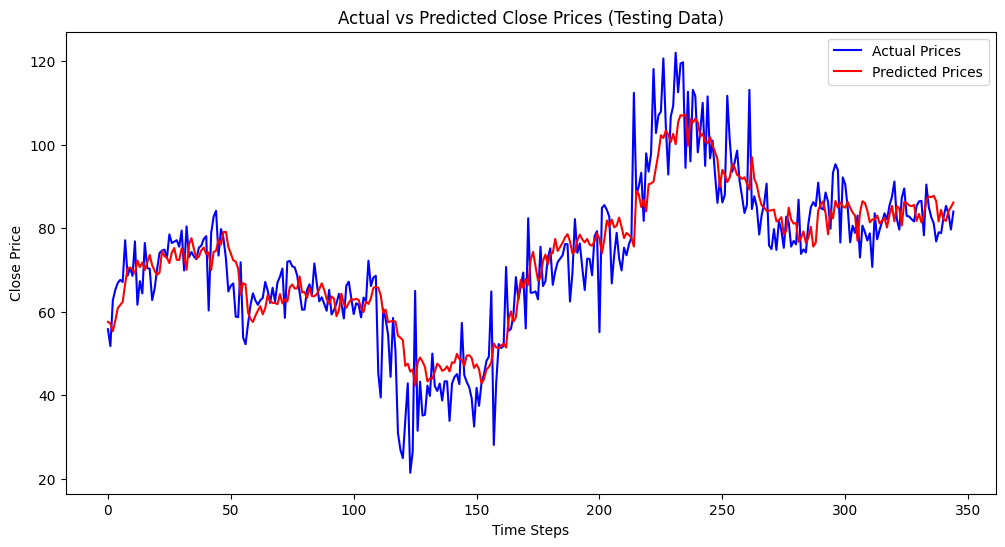

1/1 [==============================] - 0s 15ms/step
Future 3–4 Week Predictions: [86.13983 83.23491 82.34812 82.15465]


In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('brent_crude_oil_atr_ema_rsi_w.csv')
data = data.dropna()

# Drop the first 26 rows and reset index
data = data.iloc[26:].reset_index(drop=True)

# Convert Date column and sort
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

# Handle missing values by forward fill
data.interpolate(method='pad', inplace=True)

# Check for any remaining NaNs
if data.isnull().sum().sum() > 0:
    raise ValueError("There are still NaN values in the dataset!")
else:
    print("All missing values handled successfully!")

# Define features and target
features = ['Open', 'High', 'Low', 'Vol.', 'ATR', 'EMA_12', 'EMA_26', 'RSI',
            'S&P500_Close', 'S&P500_ATR', 'S&P500_EMA_12', 'S&P500_EMA_26', 'S&P500_RSI',
            'CBOE_Close', 'CBOE_ATR', 'CBOE_RSI', 'CBOE_EMA_12', 'CBOE_EMA_26',
            'USDI_Close', 'USDI_ATR', 'USDI_EMA_12', 'USDI_EMA_26', 'USDI_RSI',
            'Weekly_WTI_Contracts', 'Monthly_WTI_Contracts', 'WTI_Weekly_to_Monthly_Ratio']
target = 'Close'

# Normalize features and target
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[features + [target]])
data_scaled = pd.DataFrame(data_scaled, columns=features + [target])

# Create time-series sequences
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps, :-1])
        y.append(data[i+time_steps, -1])
    return np.array(X), np.array(y)

time_steps = 25
X, y = create_sequences(data_scaled.values, time_steps)

# Train-test split (no shuffling for time series)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

# Build GRU model
model = Sequential([
    GRU(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Add EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model with EarlyStopping
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {loss}")
print(f"Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Reverse scale the predictions and actuals
scaler_target = MinMaxScaler()
scaler_target.fit(data[[target]])
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))
predictions_rescaled = scaler_target.inverse_transform(predictions)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
accuracy = 100 - np.mean(np.abs((y_test_rescaled - predictions_rescaled) / y_test_rescaled)) * 100

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"Accuracy: {accuracy:.2f}%")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Prices', color='blue')
plt.plot(predictions_rescaled, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Close Prices (Testing Data)')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Predict next 4 weeks
future_steps = 4
last_sequence = X_test[-1]
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(last_sequence[np.newaxis, :, :])
    future_predictions.append(pred[0, 0])
    new_sequence = np.append(last_sequence[1:], [np.append(last_sequence[-1, :-1], pred[0, 0])], axis=0)
    last_sequence = new_sequence

# Reverse scale future predictions
future_predictions_rescaled = scaler_target.inverse_transform(np.array(future_predictions).reshape(-1, 1))
print(f"Future 3–4 Week Predictions: {future_predictions_rescaled.flatten()}")


### Monthly

Epoch 1/50
19/19 [==============================] - 1s 20ms/step - loss: 0.0633 - mae: 0.1947 - val_loss: 0.0229 - val_mae: 0.1328
Epoch 2/50
19/19 [==============================] - 0s 7ms/step - loss: 0.0077 - mae: 0.0626 - val_loss: 0.0053 - val_mae: 0.0525
Epoch 3/50
19/19 [==============================] - 0s 7ms/step - loss: 0.0045 - mae: 0.0437 - val_loss: 0.0047 - val_mae: 0.0484
Epoch 4/50
19/19 [==============================] - 0s 6ms/step - loss: 0.0031 - mae: 0.0356 - val_loss: 0.0046 - val_mae: 0.0489
Epoch 5/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0028 - mae: 0.0348 - val_loss: 0.0046 - val_mae: 0.0501
Epoch 6/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0024 - mae: 0.0328 - val_loss: 0.0050 - val_mae: 0.0531
Epoch 7/50
19/19 [==============================] - 0s 4ms/step - loss: 0.0023 - mae: 0.0324 - val_loss: 0.0047 - val_mae: 0.0505
Epoch 8/50
19/19 [==============================] - 0s 5ms/step - loss: 0.0022 - mae: 0.0

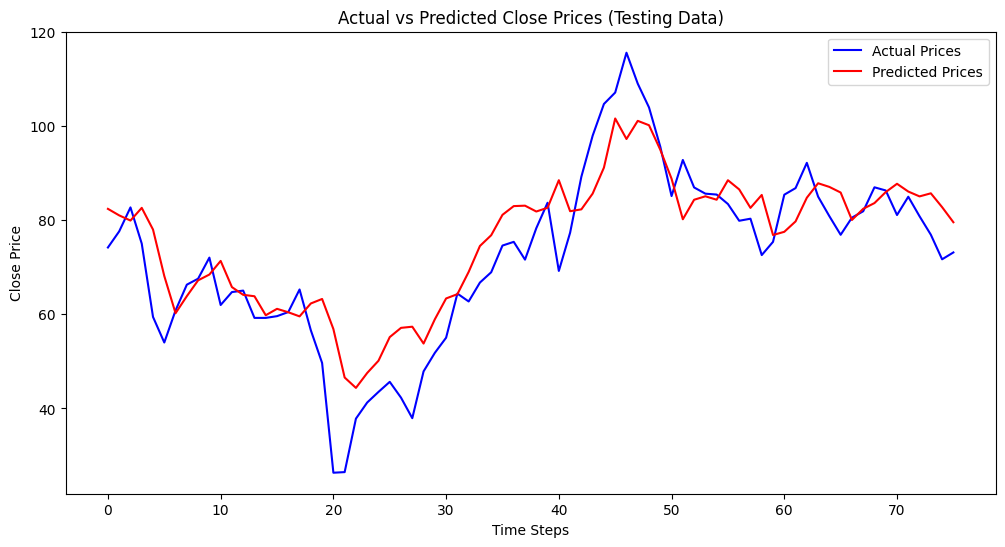

1/1 [==============================] - 0s 19ms/step
        Date  Predicted Close
0 2024-02-01        79.576149
1 2024-03-01        81.505844
2 2024-04-01        81.618675
3 2024-05-01        81.739586
4 2024-06-01        81.853752
5 2024-07-01        81.948853
6 2024-08-01        82.028061


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load your dataset
data = pd.read_csv('brent_crude_oil_atr_ema_rsi_m2.csv') 

# Drop rows with missing values
data.dropna(inplace=True)

# Convert 'Date' column to datetime format and sort the data by 'Date'
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

# Select features and target
features = [
    'Open', 'High', 'Low', 'Vol.', 'ATR', 'EMA_10', 'EMA_20', 'RSI', 
    's&p_500_Close', 's&p_500_ATR', 's&p_500_EMA_12', 's&p_500_EMA_26', 's&p_500_RSI', 
    'cboe_Close', 'cboe_ATR', 'cboe_EMA_12', 'cboe_EMA_26', 'cboe_RSI', 
    'usdi_Close', 'usdi_ATR', 'usdi_EMA_12', 'usdi_EMA_26', 'usdi_RSI'
]
target = 'Close'

# Normalize features and target
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[features + [target]])

# Convert scaled data to a DataFrame
data_scaled = pd.DataFrame(data_scaled, columns=features + [target])

# Create sequences for time-series modeling
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :-1])  # Input features
        y.append(data[i + time_steps, -1])    # Target (Close price)
    return np.array(X), np.array(y)

time_steps = 12  # Use 12 months (1 year) of data to predict the next month's close price
X, y = create_sequences(data_scaled.values, time_steps)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Build the GRU model
model = Sequential([
    GRU(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {loss}")
print(f"Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Reverse scaling for predictions and actual values
scaler_target = MinMaxScaler()
scaler_target.fit(data[[target]])
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))
predictions_rescaled = scaler_target.inverse_transform(predictions)

# Calculate RMSE, MSE, and accuracy
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
accuracy = 100 - np.mean(np.abs((y_test_rescaled - predictions_rescaled) / y_test_rescaled)) * 100

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"Accuracy: {accuracy:.2f}%")

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Prices', color='blue')
plt.plot(predictions_rescaled, label='Predicted Prices', color='red')
plt.title('Actual vs Predicted Close Prices (Testing Data)')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Predict future months
future_steps = 7  # Number of months to predict
last_sequence = X_test[-1]  # Start with the last sequence from the test set
future_predictions = []

for _ in range(future_steps):
    pred = model.predict(last_sequence[np.newaxis, :, :])  # Predict next step
    future_predictions.append(pred[0, 0])  # Append prediction
    # Update the sequence with the new prediction
    new_sequence = np.append(last_sequence[1:], [np.append(last_sequence[-1, :-1], pred[0, 0])], axis=0)
    last_sequence = new_sequence

# Reverse scale the future predictions
future_predictions_rescaled = scaler_target.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Prepare dates for future predictions (1st of each month)
last_date = data['Date'].iloc[-1]
future_dates = [(last_date + pd.DateOffset(months=i + 1)).replace(day=1) for i in range(future_steps)]

# Display future predictions with dates
future_df = pd.DataFrame({'Date': future_dates, 'Predicted Close': future_predictions_rescaled.flatten()})
print(future_df)


# Carbon Black price prediction

### Monthly 

Epoch 1/50
7/7 [==============================] - 1s 30ms/step - loss: 0.1226 - mae: 0.3100 - val_loss: 0.2351 - val_mae: 0.4623
Epoch 2/50
7/7 [==============================] - 0s 6ms/step - loss: 0.0322 - mae: 0.1455 - val_loss: 0.0545 - val_mae: 0.1883
Epoch 3/50
7/7 [==============================] - 0s 7ms/step - loss: 0.0128 - mae: 0.0926 - val_loss: 0.0311 - val_mae: 0.1346
Epoch 4/50
7/7 [==============================] - 0s 6ms/step - loss: 0.0136 - mae: 0.0949 - val_loss: 0.0366 - val_mae: 0.1508
Epoch 5/50
7/7 [==============================] - 0s 6ms/step - loss: 0.0081 - mae: 0.0741 - val_loss: 0.0489 - val_mae: 0.1774
Epoch 6/50
7/7 [==============================] - 0s 6ms/step - loss: 0.0077 - mae: 0.0723 - val_loss: 0.0468 - val_mae: 0.1741
Epoch 7/50
7/7 [==============================] - 0s 6ms/step - loss: 0.0065 - mae: 0.0652 - val_loss: 0.0367 - val_mae: 0.1505
Epoch 8/50
7/7 [==============================] - 0s 6ms/step - loss: 0.0057 - mae: 0.0619 - val_loss: 

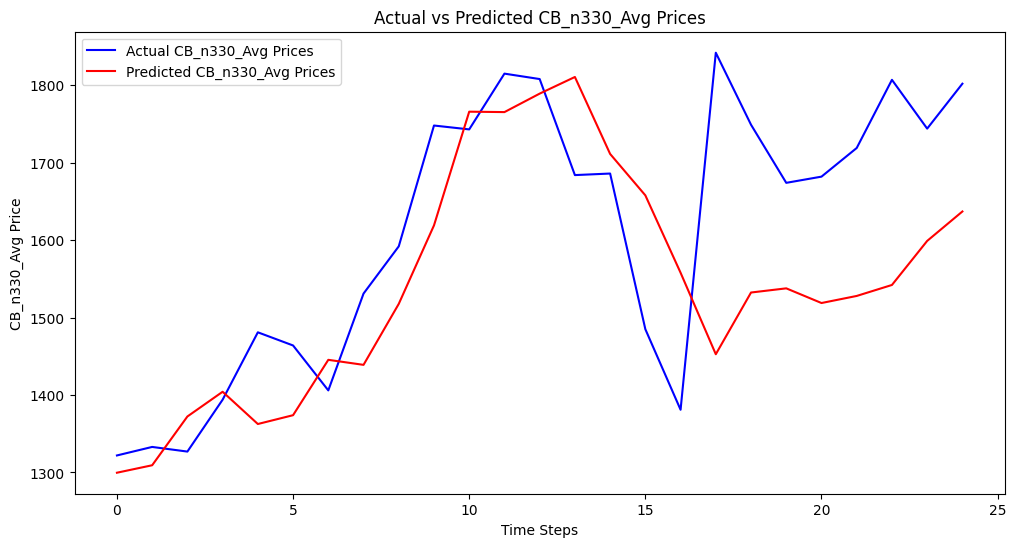

1/1 [==============================] - 0s 14ms/step
Scaled predictions before inverse transformation:
[0.8146562, 0.8203217, 0.82631415]
Rescaled predictions (Actual Values):
[[1637.0098]
 [1643.2758]
 [1649.9034]]
Min/Max of the scaled predictions: 0.8146562 0.82631415
Min/Max of the rescaled predictions: 1637.0098 1649.9034
        Date  Predicted CB_n330_Avg
0 2023-09-01            1637.009766
1 2023-10-01            1643.275757
2 2023-11-01            1649.903442


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('cb_dataset.csv')  

data.dropna(inplace=True)

data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

# Features and target
features = ['Price', 'Open', 'High', 'Low', 'Vol.', 'CB_n330_Low', 'CB_n330_High', 'BCO_Close', 'EMA_3']
target = 'CB_n330_Avg'

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[features + [target]])
data_scaled = pd.DataFrame(data_scaled, columns=features + [target])

def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :-1])
        y.append(data[i + time_steps, -1])
    return np.array(X), np.array(y)

time_steps = 12  # Using 12 months (or relevant time steps)
X, y = create_sequences(data_scaled.values, time_steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Build GRU model
model = Sequential([
    GRU(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {loss}")
print(f"Test MAE: {mae}")

predictions = model.predict(X_test)

scaler_target = MinMaxScaler()
scaler_target.fit(data[[target]])
y_test_rescaled = scaler_target.inverse_transform(y_test.reshape(-1, 1))
predictions_rescaled = scaler_target.inverse_transform(predictions)

rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
accuracy = 100 - np.mean(np.abs((y_test_rescaled - predictions_rescaled) / y_test_rescaled)) * 100

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"Accuracy: {accuracy:.2f}%")

plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual CB_n330_Avg Prices', color='blue')
plt.plot(predictions_rescaled, label='Predicted CB_n330_Avg Prices', color='red')
plt.title('Actual vs Predicted CB_n330_Avg Prices')
plt.xlabel('Time Steps')
plt.ylabel('CB_n330_Avg Price')
plt.legend()
plt.show()




# Future prediction steps
future_steps = 3
last_sequence = X_test[-1]
future_predictions = []

# Predict for the next steps
for _ in range(future_steps):
    pred = model.predict(last_sequence[np.newaxis, :, :])
    future_predictions.append(pred[0, 0])
    new_sequence = np.append(last_sequence[1:], [np.append(last_sequence[-1, :-1], pred[0, 0])], axis=0)
    last_sequence = new_sequence

# Print the raw (scaled) predictions before inverse scaling
print("Scaled predictions before inverse transformation:")
print(future_predictions)

# Rescale the predictions back to the original scale
future_predictions_rescaled = scaler_target.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Print the rescaled predictions to check the actual output
print("Rescaled predictions (Actual Values):")
print(future_predictions_rescaled)

# Check the min and max of the scaled and rescaled predictions to see if they are in reasonable range
print("Min/Max of the scaled predictions:", np.min(future_predictions), np.max(future_predictions))
print("Min/Max of the rescaled predictions:", np.min(future_predictions_rescaled), np.max(future_predictions_rescaled))

# Generate future dates based on the start date (August 2023)
start_date = pd.Timestamp('2023-08-01')
future_dates = [start_date + pd.DateOffset(months=i + 1) for i in range(future_steps)]

# Prepare the DataFrame for future predictions
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted CB_n330_Avg': future_predictions_rescaled.flatten()
})

# Print the future predictions with dates
print(future_df)
